In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 256
img_size = 28 * 28  # MNIST images are 28x28
batch_size = 64
epochs = 50
lr = 0.0002

In [18]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_size),
            nn.Tanh()  # Output between -1 and 1
        )
    
    def forward(self, z):
        return self.model(z)

In [4]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probability output
        )
    
    def forward(self, img):
        return self.model(img)

In [5]:
# Configure data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Scale to [-1, 1]
])

dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [7]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

In [8]:
# Training loop
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        # Move data to device
        real_imgs = real_imgs.view(-1, img_size).to(device)
        batch_size = real_imgs.size(0)
        
        # Adversarial labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # ===== Train Discriminator =====
        optimizer_D.zero_grad()
        
        # Real images
        outputs_real = discriminator(real_imgs)
        loss_real = criterion(outputs_real, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        outputs_fake = discriminator(fake_imgs.detach())  # Detach to avoid training G
        loss_fake = criterion(outputs_fake, fake_labels)
        
        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()
        
        # ===== Train Generator =====
        optimizer_G.zero_grad()
        
        # Generate new fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        
        # Try to fool discriminator
        outputs = discriminator(fake_imgs)
        loss_G = criterion(outputs, real_labels)  # We want fakes to be considered real
        
        loss_G.backward()
        optimizer_G.step()
        
    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}] Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch [1/50] Loss D: 0.3589, Loss G: 2.1328
Epoch [2/50] Loss D: 1.9895, Loss G: 1.4368
Epoch [3/50] Loss D: 0.2919, Loss G: 3.1783
Epoch [4/50] Loss D: 0.4061, Loss G: 2.4499
Epoch [5/50] Loss D: 0.7701, Loss G: 3.2292
Epoch [6/50] Loss D: 0.4491, Loss G: 2.5863
Epoch [7/50] Loss D: 0.4468, Loss G: 3.6447
Epoch [8/50] Loss D: 0.5228, Loss G: 3.0873
Epoch [9/50] Loss D: 0.4805, Loss G: 2.8924
Epoch [10/50] Loss D: 0.6653, Loss G: 2.0865
Epoch [11/50] Loss D: 0.6751, Loss G: 1.8719
Epoch [12/50] Loss D: 0.3366, Loss G: 2.9410
Epoch [13/50] Loss D: 0.9015, Loss G: 1.9538
Epoch [14/50] Loss D: 0.6428, Loss G: 2.4679
Epoch [15/50] Loss D: 0.9155, Loss G: 1.4629
Epoch [16/50] Loss D: 0.6756, Loss G: 1.8737
Epoch [17/50] Loss D: 0.7781, Loss G: 1.3949
Epoch [18/50] Loss D: 0.6587, Loss G: 2.5917
Epoch [19/50] Loss D: 0.7016, Loss G: 2.6876
Epoch [20/50] Loss D: 0.7998, Loss G: 1.6404
Epoch [21/50] Loss D: 0.6015, Loss G: 2.6411
Epoch [22/50] Loss D: 0.5916, Loss G: 1.8494
Epoch [23/50] Loss 

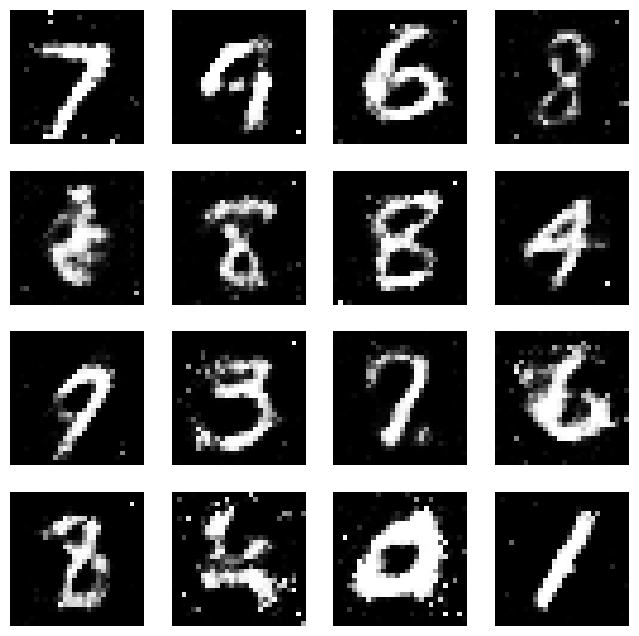

In [16]:
# Generate sample images
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    generated = generator(z).cpu().numpy()

# Plot generated images
fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    img = generated[i].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.show()